In [1]:
import xarray as xr
import rioxarray as riox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from rasterio.enums import Resampling

In [2]:
import ee 
import geemap

ee.Authenticate()
ResourceWarning

Enter verification code:  4/1AeaYSHAeU_5_110oKtl5Pdj1aF7nYuBgzpVtU-8w-CDRn16wzQOlihSZr3U



Successfully saved authorization token.


ResourceWarning

In [3]:
#ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
ee.Initialize()

In [4]:
def shp_to_geom(shapefile):
    gdf = gpd.read_file(shapefile)
    geojson = json.loads(gdf.to_json())
    coords = geojson['features'][0]['geometry']['coordinates']
    return ee.Geometry.Polygon(coords)
def reprojected_MODIS(image):
    return image.reproject('EPSG:4326',scale = 500)
def clip_image(image):
    return image.clip(basin)
def clip_bbox(image):
    return image.clipToBoundsAndScale(CH)

In [5]:
#Jonschwil_path  = "T:/Data/ewatercycle/aux_data/Thur_Jonschwil_shp/"
#gdf = gpd.read_file(Jonschwil_path)
#basin = shp_to_geom(Jonschwil_path)
#basin_bbox = ee.Geometry.BBox(*gdf.bounds.values[0])

In [6]:
dem.rio

NameError: name 'dem' is not defined

In [5]:
CH = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter('country_na == "Switzerland"').first().geometry()

In [6]:
NDSI = (ee.ImageCollection('MODIS/061/MOD10A1')
    .filterDate('2000-01-01','2023-01-01').select(('NDSI_Snow_Cover','NDSI_Snow_Cover_Class'))).map(reprojected_MODIS).filter(ee.Filter.date('2010-03-05').Not()).filter(ee.Filter.date('2013-09-17').Not())

In [7]:
#NDSI_clipped = NDSI.map(clip_image)
NDSI_cropped = NDSI.map(clip_bbox)

In [8]:
snowcover_vis = dict(min=0,max = 100,palette = ['black','0dffff','0524ff','ffffff'])

# Define a map centered on southern Maine.
m = geemap.Map(center=[47.3,9.2], zoom=10)

#m.addLayer(NDSI_cropped,snowcover_vis,'NDSI_cropped')
m.addLayer(NDSI_cropped.select('NDSI_Snow_Cover_Class').mean(),snowcover_vis,'NDSI_clipped')
m.addLayer(NDSI_cropped.select('NDSI_Snow_Cover').filterDate('2010-01-04').first(),snowcover_vis,'NDSI_date')
m.addLayer(basin_bbox,{'color':'black','alpha':0.5},'Basin')


geemap.display(m)


NameError: name 'basin_bbox' is not defined

### Xarray GEE

Riale_di_Calneggia


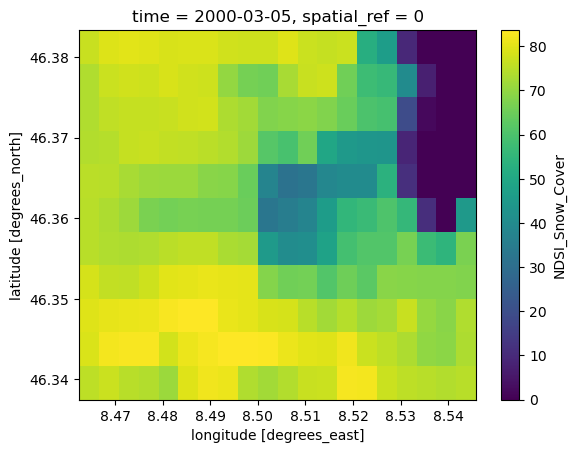

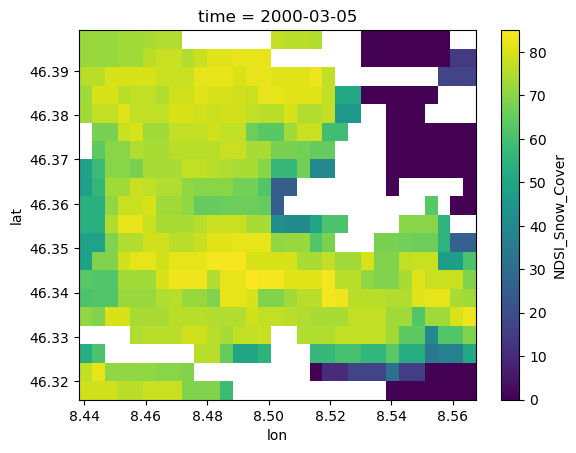

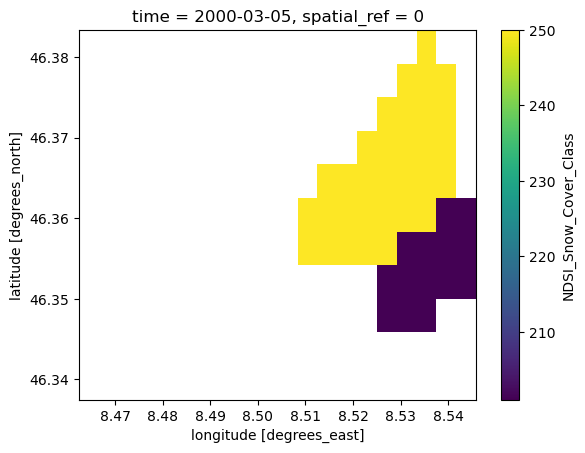

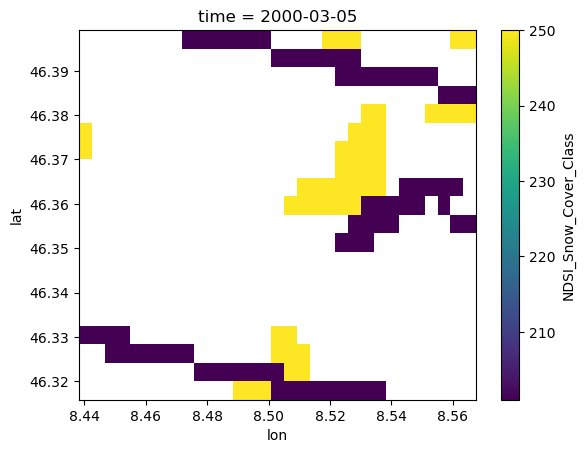

In [34]:
# basins = ['Jonschwil','Landquart','Landwasser','Rom','Verzasca']
#basins=  ['Mogelsberg','Dischma','Ova_da_Cluozza','Sitter','Werthenstein',
#              'Sense','Ilfis','Eggiwil','Chamuerabach','Veveyse','Minster',
#basins = ['Chli_Schliere','Allenbach','Kleine_Emme','Riale_di_Pincascia']
basins = ['Riale_di_Calneggia']
resolution = '500m'
for basin in basins:
    print(basin)

    dem = xr.open_dataset(f"T:/PauWiersma/Data/ewatercycle/wflow_staticmaps/staticmaps_{resolution}_{basin}_feb2024.nc")["wflow_dem"]
    dem.rio.crs
    bounds = list(dem.rio.bounds()) 
    bounds[0] -= 0.02
    bounds[1] -= 0.02
    bounds[2] += 0.02
    bounds[3] += 0.02
    bounds = tuple(bounds)
    basin_bbox = ee.Geometry.BBox(*bounds)
    NDSI_ds = xr.open_dataset(NDSI, engine = 'ee', scale = 0.0041666666, geometry = basin_bbox).transpose('time','lat','lon')
    #NDSI_ds = NDSI_ds.sel(time = NDSI_ds.time.dt.year.isin(2000))

    NDSI_ds.attrs['info'] = 'Reprojected to epsg:4326 and 500m resolution by Pau'

    big_ndsi = NDSI_ds['NDSI_Snow_Cover'].rename(dict(lat = 'y',lon = 'x')).astype(float)
    big_ndsi = big_ndsi.rio.write_nodata(np.nan)
    big_ndsi = big_ndsi.rio.interpolate_na(method = 'nearest')
    #big_ndsi = big_ndsi.interpolate_na(dim ='time', method = 'linear',max_gap = pd.Timedelta(10,'D'))
    small = dem.rename(dict(lat = 'y',lon = 'x'))
    NDSI_basin = big_ndsi.rio.reproject_match(small,resampling = Resampling.bilinear,nodata = np.nan).rename(dict(y = 'lat',x = 'lon'))
    NDSI_basin.attrs['reprojection'] = 'First gap-filled spatially with NN and then reprojected bilinearly'

    big_class = NDSI_ds['NDSI_Snow_Cover_Class'].rename(dict(lat = 'y',lon = 'x')).astype(float)
    big_class = big_class.rio.write_nodata(np.nan)
    small = dem.rename(dict(lat = 'y',lon = 'x'))
    NDSI_class_basin = big_class.rio.reproject_match(small,resampling = Resampling.mode,nodata = np.nan).rename(dict(y = 'lat',x = 'lon'))
    NDSI_class_basin.attrs['reprojection'] = 'Reprojected using mode'

    NDSI_concat = xr.merge([NDSI_basin,NDSI_class_basin])

    plt.figure()
    NDSI_basin.isel(time = 10).plot()
    plt.figure()
    NDSI_ds['NDSI_Snow_Cover'].isel(time = 10).plot()
    plt.figure()
    NDSI_class_basin.isel(time = 10).plot()
    plt.figure()
    NDSI_ds['NDSI_Snow_Cover_Class'].isel(time = 10).plot()
    plt.show()

    NDSI_concat.to_netcdf(f"T:/PauWiersma/Data/SnowCover/MOD10A_2000_2022_{resolution}_{basin}.nc")

In [30]:
basin_bbox = ee.Geometry.BBox(*dem.rio.bounds()).buffer(8)


ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Geometry.buffer",
    "arguments": {
      "distance": {
        "constantValue": 8
      },
      "geometry": {
        "functionInvocationValue": {
          "functionName": "GeometryConstructors.Polygon",
          "arguments": {
            "coordinates": {
              "constantValue": [
                [
                  [
                    8.462500000000006,
                    46.38333333333334
                  ],
                  [
                    8.462500000000006,
                    46.33750000000005
                  ],
                  [
                    8.545833333333263,
                    46.33750000000005
                  ],
                  [
                    8.545833333333263,
                    46.38333333333334
                  ]
                ]
              ]
            },
            "geodesic": {
              "constantValue": false
            }
          }
        }
      }
    }
  }
})

In [16]:
NDSI_ds['NDSI_Snow_Cover_Class'].rename(dict(lat = 'y',lon = 'x'))

<xarray.DataArray 'NDSI_Snow_Cover_Class' (time: 8277, y: 9, x: 30)>
[2234790 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2022-12-31
  * x        (x) float32 8.165 8.169 8.173 8.177 ... 8.273 8.277 8.281 8.285
  * y        (y) float32 46.97 46.96 46.96 46.96 46.95 46.95 46.94 46.94 46.94
Attributes:
    id:             NDSI_Snow_Cover_Class
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max'...
    crs:            EPSG:4326
    crs_transform:  [0.004491576420597608, 0, 0, 0, -0.004491576420597608, 0]

In [306]:
NDSI_concat.time

<xarray.DataArray 'time' (time: 8277)>
array(['2000-02-24T00:00:00.000000000', '2000-02-25T00:00:00.000000000',
       '2000-02-26T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2022-12-31
    spatial_ref  int32 0

In [292]:
big_ndsi.interpolate_na(dim ='time', method = 'linear',max_gap = pd.Timedelta(10,'D'))

<xarray.DataArray 'NDSI_Snow_Cover' (time: 8277, y: 66, x: 98)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [10.77777778, 10.77777778, 47.66666667, ..., 54.        ,
         54.        , 53.        ],
        [ 4.88888889,  3.66666667,  3.66666667, ..., 57.        ,
         57.        , 53.        ],
        [ 6.44444444,  5.11111111,  5.11111111, ..., 56.        ,
         56.        , 56.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [10.        , 10.        , 51.        , ..., 73.        ,
         71.        ,         nan],
        [ 0.        ,  0.        ,  0.        , ..., 78.        ,
         78.        , 73.        ],
        [ 0.        ,  0.        ,  0.        , ..., 75.        ,
         75.        , 76.        ]]])
Coordinates:
  * time     (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2022-12-31
  * x        (x) float32 8.965 8.969 8.973 8.977 ... 9.356 9.36 9.365 9.369
  * y        (y) float32 47.41 47.41 47.4 47.4 47.39 ... 47.15 47.15 47.14 47.14
Attributes:
    id:             NDSI_Snow_Cover
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max'...
    crs:            EPSG:4326
    crs_transform:  [0.004491576420597608, 0, 0, 0, -0.004491576420597608, 0]
    _FillValue:     nan

In [279]:
print(NDSI_concat)

<xarray.Dataset>
Dimensions:                (time: 300, lon: 25, lat: 15)
Coordinates:
  * time                   (time) datetime64[ns] 2000-02-24 ... 2000-12-31
    spatial_ref            int32 0
  * lon                    (lon) float64 10.29 10.3 10.3 ... 10.47 10.48 10.49
  * lat                    (lat) float64 46.65 46.65 46.64 ... 46.55 46.55 46.54
Data variables:
    NDSI_Snow_Cover        (time, lat, lon) float64 nan nan nan ... 74.7 74.34
    NDSI_Snow_Cover_Class  (time, lat, lon) float64 201.0 201.0 ... nan nan
Attributes:
    id:             NDSI_Snow_Cover
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max'...
    crs_transform:  [0.004491576420597608, 0, 0, 0, -0.004491576420597608, 0]
    _FillValue:     nan


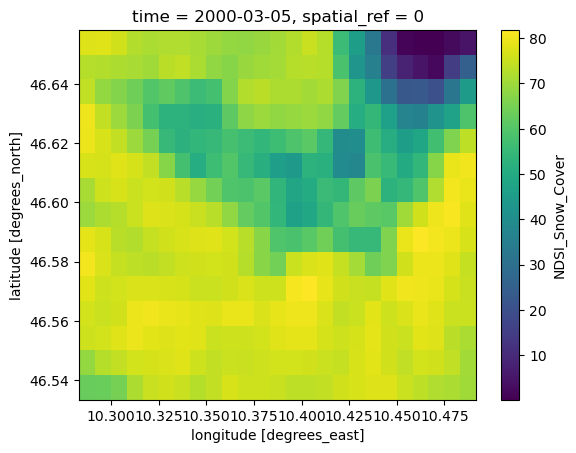

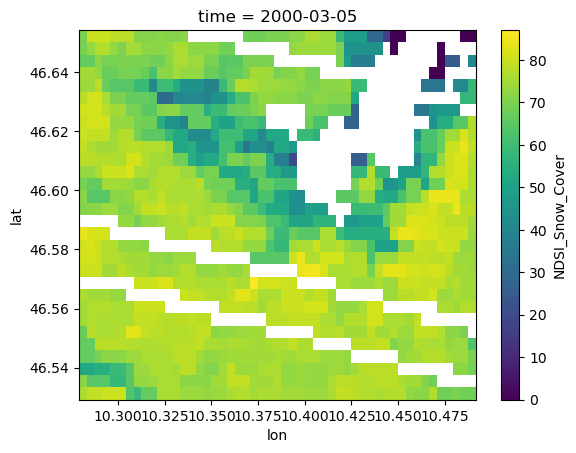

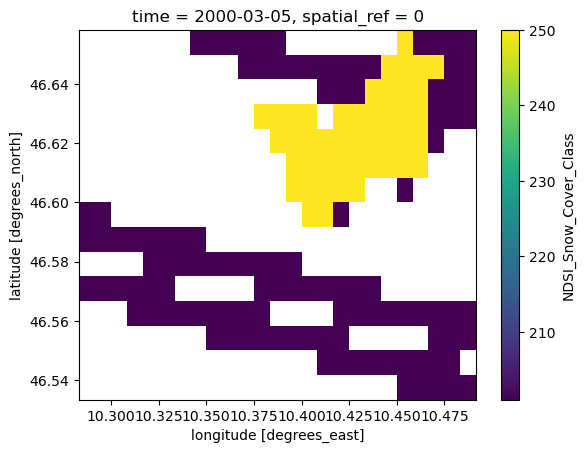

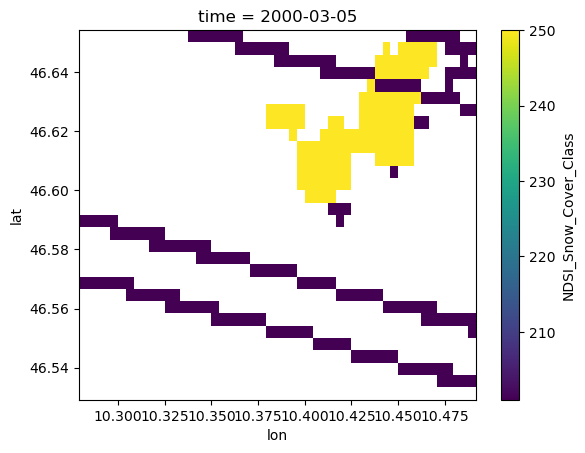